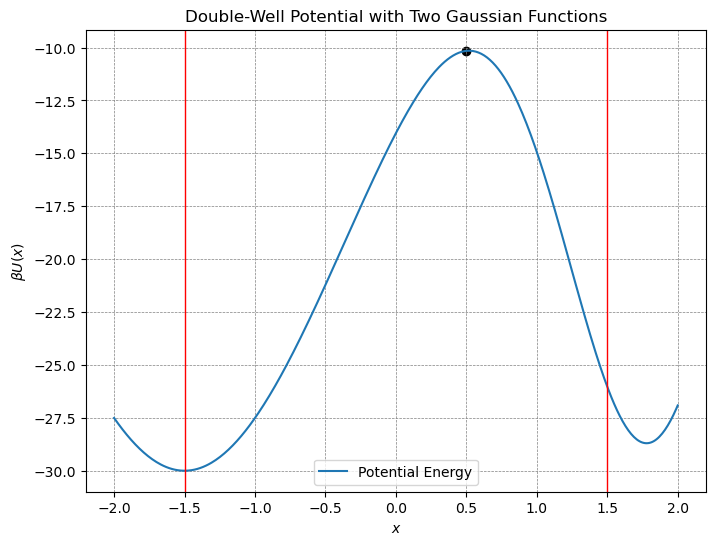

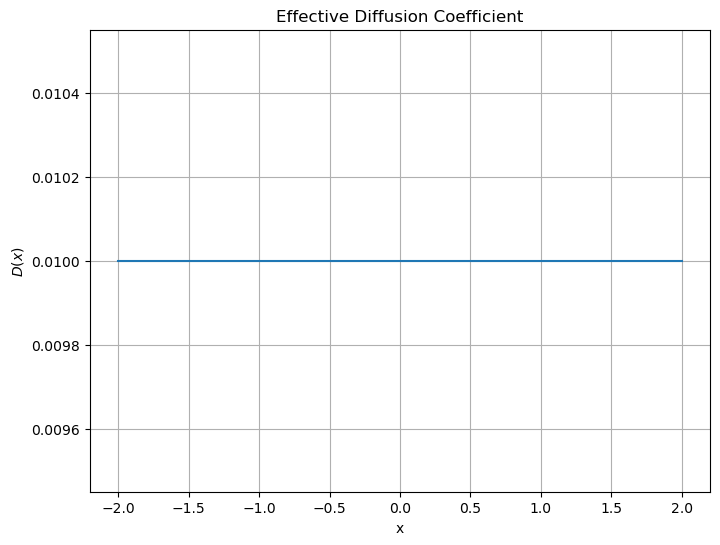

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator

# Define the double-well potential using two Gaussian functions
def double_gaussian_potential(x, A1=30, mu1=-1.5, sigma1=1.2, A2=28, mu2=1.8, sigma2=0.6):
# def double_gaussian_potential(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
# def double_gaussian_potential(x, A1=30, mu1=-1, sigma1=0.5, A2=25, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(1.5, color='red',linewidth=1)
plt.axvline(-1.5, color='red',linewidth=1)
plt.scatter(0.5, beta_U(0.5), color='black')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, D(x))
plt.xlabel('x')
plt.ylabel("$D(x)$")
plt.title('Effective Diffusion Coefficient')
plt.grid(True)
plt.show()

In [2]:
a = 0.5   # location of reflecting boundary (will be used twice)
b1 = -1.5   # location of lower absorbing boundary
b2 = 1.5   # location of upper absorbing boundary
h = 0.001
N1 = int((a-b1)/h+1)
N2 = int((b2-a)/h+1)
x1_arr = np.linspace(b1, a, N1)
x2_arr = np.linspace(a, b2, N2)

In [3]:
from transfer_matrix_reptile import TransferMatrix_InReAb, TransferMatrix_AbReIn

ari1_trans = TransferMatrix_AbReIn(h, x1_arr, beta_U, 0)
ira2_trans = TransferMatrix_InReAb(h, x2_arr, beta_U, 0)

# from mfpt_Pst_RW_simulate import simulate_AbRe, simulate_ReAb

# num_particles = 50
# init_position = a
# hx = h
# ht = hx**2/(2*D0)
# n1_arr = np.arange(b1, a+h, h)
# n1_arr = np.round(n1_arr, decimals=5)
# count_n1, ti_n1 = simulate_AbRe(init_point=init_position, num_particles=num_particles, beta_U=beta_U, n_arr=n1_arr, a=a, b=b1, hx=hx)

# n2_arr = np.arange(a, b2+h, h)
# n2_arr = np.round(n2_arr, decimals=5)
# count_n2, ti_n2 = simulate_ReAb(init_point=init_position, num_particles=num_particles, beta_U=beta_U, n_arr=n2_arr, a=a, b=b2, hx=hx)

[1.        +0.00000000e+00j 0.99999456-1.59656388e-05j
 0.99999456+1.59656388e-05j 0.99997935-3.27671311e-05j
 0.99997935+3.27671311e-05j 0.99995475-4.96266674e-05j]
[1.        +0.00000000e+00j 0.99997594-5.02383521e-05j
 0.99997594+5.02383521e-05j 0.99991558-1.05649345e-04j
 0.99991558+1.05649345e-04j 0.9998177 -1.60191664e-04j]


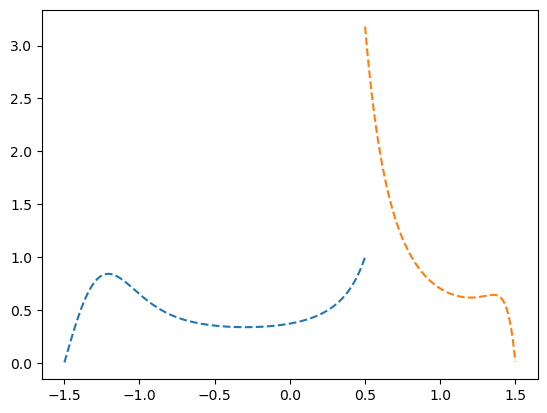

In [4]:
print(ari1_trans.eig6_w)
print(ira2_trans.eig6_w)
def get_steady_state(ria_trans):
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    steady_state = ria_trans.eig6_v[:,idx_fixed_vect].real/(h*np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real))
    return steady_state

ari1_trans.steady_state = get_steady_state(ari1_trans)
ira2_trans.steady_state = get_steady_state(ira2_trans)
plt.plot(x1_arr[1:], ari1_trans.steady_state, '--', label="ARI-Pst")
plt.plot(x2_arr[:-1], ira2_trans.steady_state, '--', label="IRA-Pst")

# Pst_n1 = count_n1/(h*np.sum(count_n1))
# Pst_n2 = count_n2/(h*np.sum(count_n2))
# plt.plot(n1_arr[1:], Pst_n1[1:], label="Metro walkers (AbRe)")
# plt.plot(n2_arr[:-1], Pst_n2[:-1], label="Metro walkers (ReAb)")

# plt.xlabel('x')
# plt.ylabel("probability distribution $P(x)$")
# plt.legend()
# plt.grid()

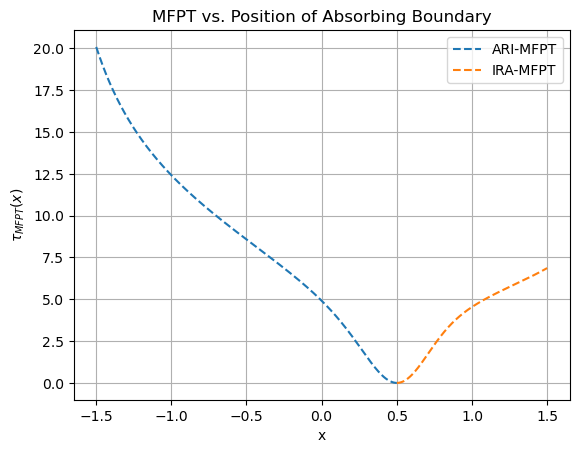

In [5]:
def mfpt_matrix(transMat_instance):
    ria_trans = transMat_instance
    ria_P = ria_trans.trans_mat.T
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    vec_pi = ria_trans.eig6_v[:,idx_fixed_vect].real/np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real)
    N = vec_pi.size
    epsilon = np.ones(N)
    mat_I = np.eye(N)
    mat_E = np.ones((N, N))
    mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
    vec_Zdg = np.diag(mat_Z)
    mat_Zdg = np.diag(vec_Zdg)
    mat_Mdg = np.diag(1/vec_pi)
    mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
    mat_Mbar = mat_M - mat_Mdg
    return mat_Mbar

m1_bar = mfpt_matrix(ari1_trans)
m2_bar = mfpt_matrix(ira2_trans)
delt_t = h**2/(2*D0)
plt.plot(x1_arr[1: ], delt_t*m1_bar[-1], '--', label="ARI-MFPT")
plt.plot(x2_arr[:-1], delt_t*m2_bar[0], '--', label="IRA-MFPT")

# mfpt1_simu_arr = ht*np.mean(ti_n1, axis=0)
# mfpt2_simu_arr = ht*np.mean(ti_n2, axis=0)
# plt.plot(n1_arr[1:], mfpt1_simu_arr[1:], label="Metro walkers (AbRe)")
# plt.plot(n2_arr[:-1], mfpt2_simu_arr[:-1], label="Metro walkers (ReAb)")

plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.title('MFPT vs. Position of Absorbing Boundary')
plt.legend()
plt.grid()

#### Steady-State Flux and Probability Distribution Function - Numerically Nest integrate the expression (referred to be exact) 

In [6]:
# Define the inner function to integrate as a function of y
def inner_integrand(y):
    return 1.0/D(y)*np.exp(beta_U(y))

# Define the inner integral as a function of x
def inner_integral(x):
    y_lower = b1
    y_upper = x
    result, error = quad(inner_integrand, y_lower, y_upper)
    return result

# Define the outer integral
x_lower = b1
x_upper = a

# Define the outer function to integrate (also as a function of x)
def outer_integrand(x):
    return -np.exp(-beta_U(x))*inner_integral(x)

# Perform the outer integration
invert_st1_flux, error = quad(outer_integrand, x_lower, x_upper)
st1_flux = 1.0/invert_st1_flux

# Define the inner function to integrate as a function of y
def inner_integrand(y):
    return 1.0/D(y)*np.exp(beta_U(y))

# Define the inner integral as a function of x
def inner_integral(x):
    y_lower = x
    y_upper = b2
    result, error = quad(inner_integrand, y_lower, y_upper)
    return result

# Define the outer integral
x_lower = a
x_upper = b2

# Define the outer function to integrate (also as a function of x)
def outer_integrand(x):
    return np.exp(-beta_U(x))*inner_integral(x)

invert_st2_flux, error = quad(outer_integrand, x_lower, x_upper)
st2_flux = 1.0/invert_st2_flux
print(st1_flux, st2_flux)

-0.04996095849031099 0.14683100093591187


In [7]:
def st1_P_func(x):
    def integrand(y):
        return 1.0/D(y)*np.exp(beta_U(y))
    # Perform the integration
    y_lower = b1
    y_upper = x
    result, error = quad(integrand, y_lower, y_upper)
    result *= -st1_flux*np.exp(-beta_U(x))
    return result

st1_P_arr = np.zeros(x1_arr.size)
for i in np.arange(x1_arr.size):
    st1_P_arr[i] = st1_P_func(x1_arr[i])

def st2_P_func(x):
    def integrand(y):
        return 1.0/D(y)*np.exp(beta_U(y))
    # Perform the integration
    y_lower = x
    y_upper = b2
    result, error = quad(integrand, y_lower, y_upper)
    result *= st2_flux*np.exp(-beta_U(x))
    return result

st2_P_arr = np.zeros(x2_arr.size)
for i in np.arange(x2_arr.size):
    st2_P_arr[i] = st2_P_func(x2_arr[i])

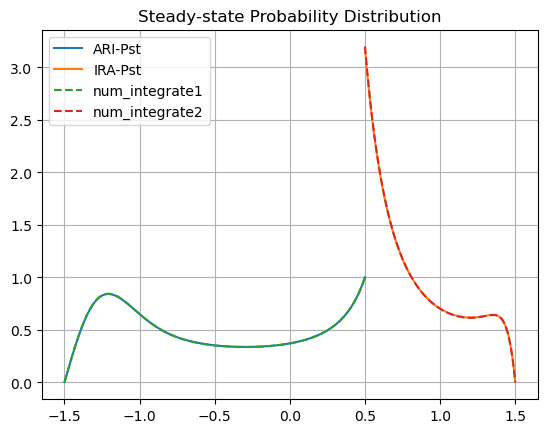

In [8]:
plt.plot(x1_arr[1:], ari1_trans.steady_state.real, label="ARI-Pst")
plt.plot(x2_arr[:-1], ira2_trans.steady_state.real, label="IRA-Pst")
plt.plot(x1_arr, st1_P_arr, '--', label='num_integrate1')
plt.plot(x2_arr, st2_P_arr, '--', label='num_integrate2')
plt.title('Steady-state Probability Distribution')
plt.grid()
plt.legend()

/tmp/ipykernel_23153/2873600556.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x1_arr, -np.log(st1_P_arr), '--', label='num_integrate1')
/tmp/ipykernel_23153/2873600556.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x2_arr, -np.log(st2_P_arr), '--', label='num_integrate2')


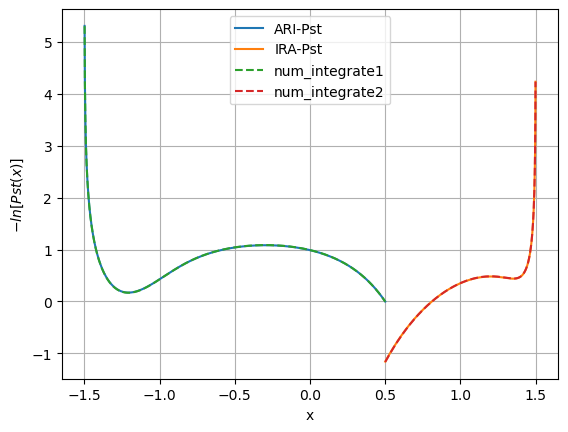

In [9]:
plt.plot(x1_arr[1:], -np.log(ari1_trans.steady_state.real), label="ARI-Pst")
plt.plot(x2_arr[:-1], -np.log(ira2_trans.steady_state.real), label="IRA-Pst")
plt.plot(x1_arr, -np.log(st1_P_arr), '--', label='num_integrate1')
plt.plot(x2_arr, -np.log(st2_P_arr), '--', label='num_integrate2')
plt.xlabel('x')
plt.ylabel("$-ln[Pst(x)]$")
plt.grid()
plt.legend()

#### Numerically Nest integrate for MFPT - referred to be exact

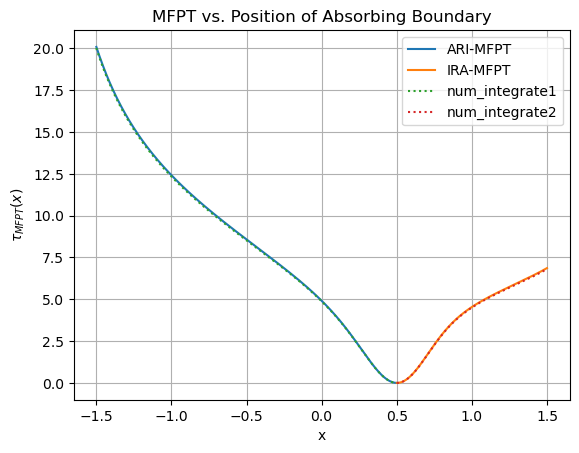

In [10]:
x0 = a   # Regura's method, overlap the starting point and reflecting boundary
# Define the inner function to integrate as a function of z
def inner_integrand(z):
    return np.exp(-beta_U(z))

# Define the inner integral as a function of y
def inner_integral(y):
    z_lower = a
    z_upper = y
    result, error = quad(inner_integrand, z_lower, z_upper)
    return result

# Define the outer integral2
y_lower = x0
y_upper = b2
# Define the outer function to integrate (also as a function of y)
def outer_integrand(y):
    return np.exp(beta_U(y))*inner_integral(y)/D(y)
mfpt2_arr = np.zeros(x2_arr.size)
for i in np.arange(x2_arr.size):
    mfpt2_arr[i], _ = quad(outer_integrand, y_lower, x2_arr[i])

# Define the outer integral1
y_lower = x0
y_upper = b1
# Define the outer function to integrate (also as a function of y)
def outer_integrand(y):
    return np.exp(beta_U(y))*inner_integral(y)/D(y)
mfpt1_arr = np.zeros(x1_arr.size)
for i in np.arange(x1_arr.size):
    mfpt1_arr[i], _ = quad(outer_integrand, y_lower, x1_arr[i])

plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.plot(x1_arr[1: ], delt_t*m1_bar[-1], label="ARI-MFPT")
plt.plot(x2_arr[:-1], delt_t*m2_bar[0], label="IRA-MFPT")
plt.plot(x1_arr, mfpt1_arr,':', label='num_integrate1')
plt.plot(x2_arr, mfpt2_arr, ':',  label='num_integrate2')
plt.title('MFPT vs. Position of Absorbing Boundary')
plt.legend()
plt.grid()

### Define Functions for Reconstructing Free Energy with MFPT and steady state distribution

In [11]:
def reconstruct_energy_ra(x_arr, Pst_arr, mfpt_arr):
    interp_Pst_func = interp1d(x_arr[:-1], np.array(Pst_arr, dtype=float), kind='cubic', fill_value="extrapolate")
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

    interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
        beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]
    plt.plot(x_arr[1:-1], integral_invertBx_arr)
    plt.show()
    return beta_Grec2_arr

def reconstruct_energy_ar(x_arr, Pst_arr, mfpt_arr):
    interp_Pst_func = interp1d(x_arr[1:], np.array(Pst_arr, dtype=float), kind='cubic', fill_value="extrapolate")
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[0], x_arr[1+i])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]+(mfpt_arr[1+i]-mfpt_arr[0])/mfpt_arr[0])

    interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1+i], x_arr[-2])
        beta_Grec2_arr[i] = beta_U(x_arr[-2])+np.log(Bx_arr[i]/Bx_arr[-1])-integral_invertBx_arr[i]
    plt.plot(x_arr[1:-1], integral_invertBx_arr)
    plt.show()
    return beta_Grec2_arr

#### Test Reconstruction Function with Exact Data

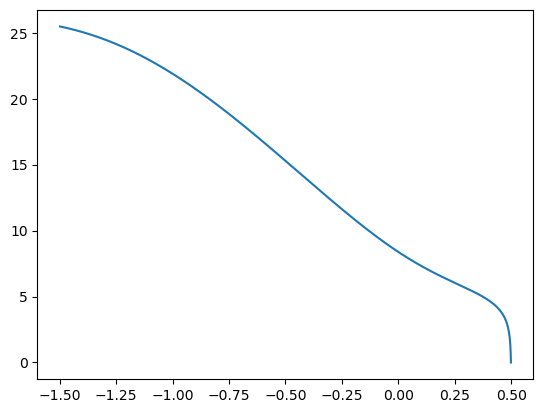

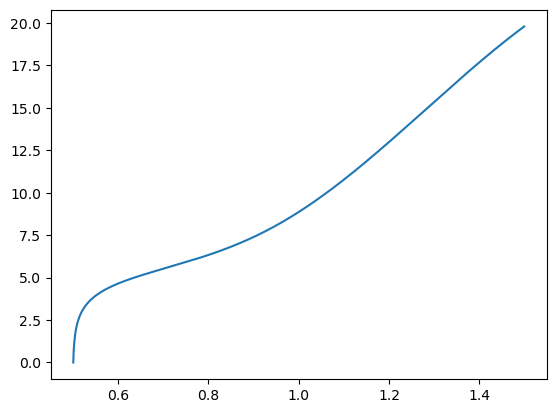

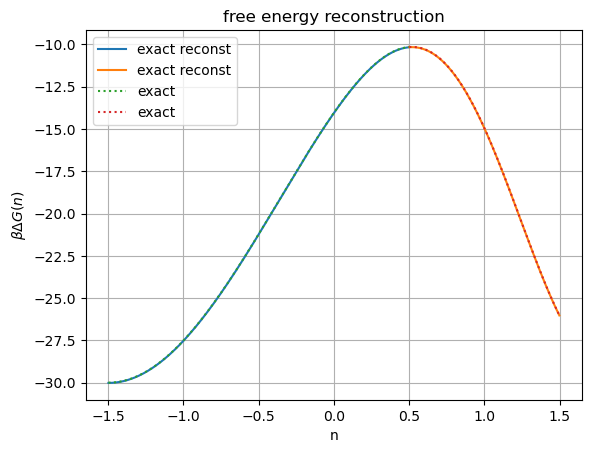

In [12]:
exact_beta_Grec2_arr1 = reconstruct_energy_ar(x1_arr, Pst_arr=st1_P_arr[1:], mfpt_arr=mfpt1_arr)
exact_beta_Grec2_arr2 = reconstruct_energy_ra(x2_arr, Pst_arr=st2_P_arr[:-1], mfpt_arr=mfpt2_arr)

plt.plot(x1_arr[1:-1], exact_beta_Grec2_arr1, label="exact reconst")
plt.plot(x2_arr[1:-1], exact_beta_Grec2_arr2, label="exact reconst")

plt.plot(x1_arr[1:-1], beta_U(x1_arr[1:-1]), ':', label="exact")
plt.plot(x2_arr[1:-1], beta_U(x2_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

### Reconstruction Using data [mfpt matrix (mat_Mbar[i]), Pst (ria_trans.steady_state)] calculated by Transfer Matrix

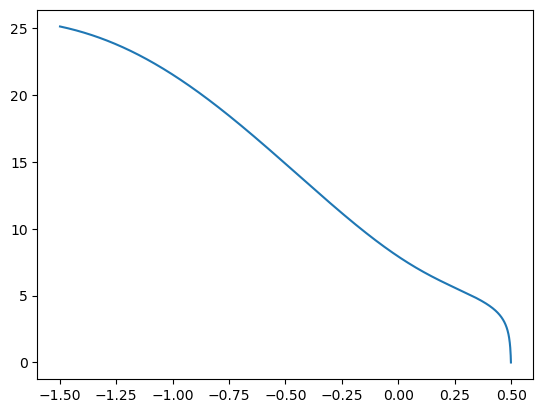

/tmp/ipykernel_23153/580950325.py:17: RuntimeWarning: invalid value encountered in log
  beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]


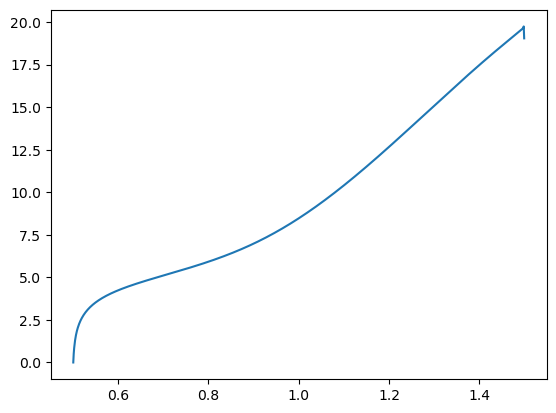

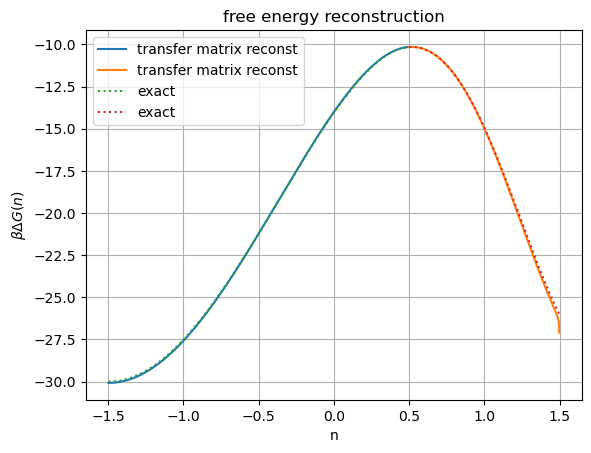

In [13]:
beta_Grec2_arr1 = reconstruct_energy_ar(x1_arr, Pst_arr=ari1_trans.steady_state.real, mfpt_arr=m1_bar[-1])
beta_Grec2_arr2 = reconstruct_energy_ra(x2_arr, Pst_arr=ira2_trans.steady_state.real, mfpt_arr=m2_bar[0])

plt.plot(x1_arr[1:-1], beta_Grec2_arr1, label="transfer matrix reconst")
plt.plot(x2_arr[1:-1], beta_Grec2_arr2, label="transfer matrix reconst")

plt.plot(x1_arr[1:-1], beta_U(x1_arr[1:-1]), ':', label="exact")
plt.plot(x2_arr[1:-1], beta_U(x2_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

### Reconstruction Using data [mfpt (mfpt1_simu_arr), Pst (Pst_n)] extracted from simulation

In [14]:
beta_Grec2_arr1 = reconstruct_energy_ar(n1_arr, Pst_arr=Pst_n1[1:], mfpt_arr=mfpt1_simu_arr[1:])
beta_Grec2_arr2 = reconstruct_energy_ra(n2_arr, Pst_arr=Pst_n2[:-1], mfpt_arr=mfpt2_simu_arr[:-1])

plt.plot(n1_arr[1:-1], beta_Grec2_arr1-0.1, label="AbRe_simu reconst")
plt.plot(n2_arr[1:-1], beta_Grec2_arr2, label="ReAb_simu reconst")

plt.plot(x1_arr[1:-1], beta_U(x1_arr[1:-1]), ':', label="exact")
plt.plot(x2_arr[1:-1], beta_U(x2_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

NameError: name 'n1_arr' is not defined

In [15]:
beta_Grec2_arr1[-20:]

array([-1.25997148, -1.25667328, -1.2551093 , -1.24527244, -1.23203672,
       -1.23407583, -1.23230236, -1.22949528, -1.23305181, -1.23856571,
       -1.24467612, -1.24849314, -1.26080078, -1.26711689, -1.27091828,
       -1.28088012, -1.29515315, -1.30405268, -1.31969063, -1.39244033])